# ResNet26 ($B = [5, 4, 3]$) Performance


Upload [resnet3l.py](https://github.com/JinchengLiang/DLminiproject/blob/main/resnet3l.py) frist.

In [1]:
from resnet3l import *

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
# import argparse

# from models import *
# from utils import progress_bar
import time
cur_time = time.time()
str_time = str(int(cur_time)) # used to rename file

## Preparing Data<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)



In [3]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:03<00:00, 43968821.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Build Model<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)


In [4]:
# Model
print('==> Building model..')
net = ResNet(BasicBlock, [5, 4, 3])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

'''if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']'''

criterion = nn.CrossEntropyLoss()
'''optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)'''
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


## Define Train Function<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)

In [5]:
# Training
def train(epoch):
    # print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        '''progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' 
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))'''
    aver_train_loss = float(train_loss/(batch_idx+1))
    aver_train_accuracy = float(correct/total)
    return aver_train_loss, aver_train_accuracy

## Define Test Function<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)

In [6]:
best_acc = 0  # best test accuracy
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            '''progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' 
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))'''

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        # print('Saving..')
        state = {'net': net.state_dict(), 'acc': acc, 'epoch': epoch,}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_' + str_time + '.pth')
        best_acc = acc

    aver_test_loss = float(test_loss / (batch_idx + 1))
    aver_test_accuracy = float(correct / total)
    return aver_test_loss, aver_test_accuracy

## Training and Test

In [7]:
import json
import collections

EPOCH = 200
start_epoch = 0 # start from epoch 0 or last checkpoint epoch
JSON_FILE = './epoch_data_Resnet_'+ str_time +'.json'
epoch_data = collections.OrderedDict()
for epoch in range(start_epoch, start_epoch+200):
    train_loss, train_accuracy = train(epoch)
    epoch_data[epoch] = {'train_loss': train_loss, 'train_accuracy': train_accuracy}
    test_loss, test_accuracy = test(epoch)
    epoch_data[epoch]['test_loss'], epoch_data[epoch]['test_accuracy'] = test_loss, test_accuracy
    scheduler.step()
    if epoch % 10 == 9:
      print(f'Epoch {epoch+1}/{EPOCH}, Train Loss {train_loss:.3f}, Train Acc {train_accuracy:.3f}, Test Loss {test_loss:.3f}, Test Acc {test_accuracy:.3f}')

epoch_data_json = json.dumps(epoch_data)
json_file = open(JSON_FILE, 'w')
json_file.write(epoch_data_json)
json_file.close()
print(f'Best Acc: {best_acc}%')

Epoch 10/200, Train Loss 0.579, Train Acc 0.800, Test Loss 0.640, Test Acc 0.778
Epoch 20/200, Train Loss 0.439, Train Acc 0.850, Test Loss 0.547, Test Acc 0.815
Epoch 30/200, Train Loss 0.388, Train Acc 0.867, Test Loss 0.461, Test Acc 0.844
Epoch 40/200, Train Loss 0.357, Train Acc 0.878, Test Loss 0.717, Test Acc 0.773
Epoch 50/200, Train Loss 0.337, Train Acc 0.886, Test Loss 0.487, Test Acc 0.842
Epoch 60/200, Train Loss 0.310, Train Acc 0.893, Test Loss 0.400, Test Acc 0.868
Epoch 70/200, Train Loss 0.291, Train Acc 0.900, Test Loss 0.520, Test Acc 0.828
Epoch 80/200, Train Loss 0.269, Train Acc 0.908, Test Loss 0.372, Test Acc 0.880
Epoch 90/200, Train Loss 0.241, Train Acc 0.918, Test Loss 0.477, Test Acc 0.855
Epoch 100/200, Train Loss 0.217, Train Acc 0.925, Test Loss 0.376, Test Acc 0.880
Epoch 110/200, Train Loss 0.187, Train Acc 0.936, Test Loss 0.327, Test Acc 0.894
Epoch 120/200, Train Loss 0.156, Train Acc 0.945, Test Loss 0.328, Test Acc 0.894
Epoch 130/200, Train Loss

## Data Analysis<sup>

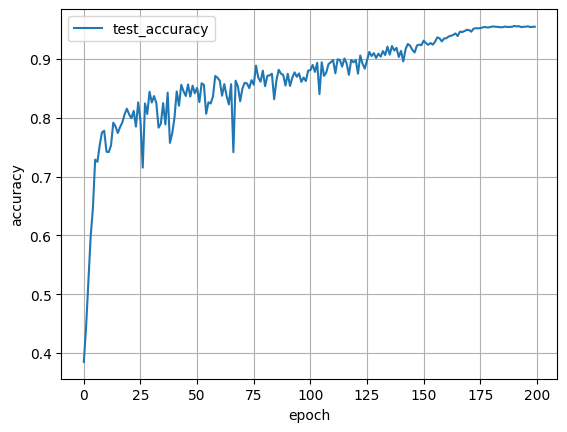

In [8]:
import matplotlib.pyplot as plt

f = open(JSON_FILE)
data1 = json.load(f)
f.close()

FEATURE = 'test_accuracy'

x = [i for i in range(EPOCH)]
feature1 = [data1[str(k)][FEATURE] for k in range(EPOCH)]

plt.plot(x, feature1, label=FEATURE)
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()
